# Welcome to this lovely notebook. This is the extention of the notebook EDA with data preprocessing and modeling parts

## In this notebook we are going to implement the following:

1. Runnig the base version of the 5 chosen models (Logistic regression, Decision Trees, Random Forest, XGBoost, CatBoost)
2. After running the base version of the model, we'll create a pipe line with gridsearch and various parameters for getting the best parameters and score

## Importing all required libraries

In [32]:
#importing all the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set the option to display all columns
pd.set_option('display.max_columns', None)

# metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,\
classification_report, precision_recall_curve, auc, make_scorer, fbeta_score

# Encoding
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# SMOTE Oversampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# RFECV
from sklearn.model_selection import StratifiedKFold

# Machine Learning - Preparation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline

# Machine Learning - Algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

## Let's get the data

In [17]:
data = pd.read_csv('fraud_vihecles.csv')

In [18]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:60% !important; }</style>"))

data.head(3)

C:\Users\atans\AppData\Local\Temp\ipykernel_12240\581277815.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Days_Policy_Accident,Days_Policy_Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,more than 69000,0,1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,more than 69000,0,2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,more than 69000,0,3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision


In [19]:
data[data['Age']==0]['AgeOfPolicyHolder'].value_counts()

AgeOfPolicyHolder
16 to 17    320
Name: count, dtype: int64

In [20]:
# Check the correlation
print(data[['PolicyNumber', 'FraudFound_P']].corr())

              PolicyNumber  FraudFound_P
PolicyNumber      1.000000     -0.020345
FraudFound_P     -0.020345      1.000000


## 1.Let's split the data

In [21]:
# Set X and y
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Split the data with stratification on the target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## 2. Dropping the useless columns

In [22]:
# Define the custom function to drop specified columns
def drop_columns(X, columns_to_drop):
    return X.drop(columns=columns_to_drop)

# List of columns to drop
columns_to_drop = ['PolicyNumber'] #['WeekOfMonth', 'DayOfWeek', 'RepNumber', , 'Age']

# Create the transformer
drop_columns_transformer = FunctionTransformer(drop_columns, kw_args={'columns_to_drop': columns_to_drop})

# Apply the transformer
X_train_removed_columns = drop_columns_transformer.transform(X_train)
X_test_removed_columns = drop_columns_transformer.transform(X_test)

## 3. Encoding

### Hot encoding the train and test data

In [23]:
# Create the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the data (train and test)
X_train_cat_transformed = encoder.fit_transform(X_train_removed_columns)
X_test_cat_transformed = encoder.transform(X_test_removed_columns)

# Convert the result to a DataFrame for better readability
X_train_encoded = pd.DataFrame(X_train_cat_transformed.toarray(), columns=encoder.get_feature_names_out(X_train_removed_columns.columns))
X_test_encoded = pd.DataFrame(X_test_cat_transformed.toarray(), columns=encoder.get_feature_names_out(X_test_removed_columns.columns))

In [24]:
X_train_encoded.shape, X_test_encoded.shape

((11565, 243), (3855, 243))

### The data is ready. Let's start modeling

## 4. Modeling with Logistic regression

#### 4.1 Building a benchmark model to take a look what we have

In [413]:
# first let's instantiate the model
lr = LogisticRegression(max_iter=10000)

# Let's fit
lr.fit(X_train_encoded, y_train)
#lr.fit(X_train_label_encoded, y_train) Label encoding didn't help improving the Logistic regression at all

LogisticRegression(max_iter=10000)

#### Train

In [414]:
# Running on train data
cm = confusion_matrix(y_true=y_train,
                      y_pred=lr.predict(X_train_encoded))
print(pd.DataFrame(cm,
             index=lr.classes_,
             columns=lr.classes_))

print(classification_report(y_train, lr.predict(X_train_encoded)))

       0   1
0  10851  22
1    672  20
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10873
           1       0.48      0.03      0.05       692

    accuracy                           0.94     11565
   macro avg       0.71      0.51      0.51     11565
weighted avg       0.91      0.94      0.91     11565



#### Test

In [415]:
# Running on test data
cm = confusion_matrix(y_true=y_test,
                      y_pred=lr.predict(X_test_encoded))
print(pd.DataFrame(cm,
             index=lr.classes_,
             columns=lr.classes_))
print(classification_report(y_test, lr.predict(X_test_encoded)))

      0   1
0  3614  10
1   229   2
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3624
           1       0.17      0.01      0.02       231

    accuracy                           0.94      3855
   macro avg       0.55      0.50      0.49      3855
weighted avg       0.89      0.94      0.91      3855



#### 4.2 Pipeline with gridsearch and finding the best hyperparameters and learning the metrics

In [416]:
# Load the data 
data = pd.read_csv('fraud_vihecles.csv')

# Set X and y
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Split the data with stratification on the target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# List of columns to drop
columns_to_drop = ['PolicyNumber', 'Age'] #'WeekOfMonth', 'DayOfWeek', 'RepNumber', 

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns.difference(columns_to_drop))
    ],
    remainder='passthrough'
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100], # , 1, 10, 100 were tried and they are not effective
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__class_weight': [None, 'balanced']
}

# SMOTE and under-sampling configurations based on the requirements
smote_configs = [
    # 1. Keep the original class proportion
    {'smote': None, 'under_sampler': None},
    
    # 2. Keep the same fraud, downsample non-fraudulent rows by 40%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.6, random_state=42)},
    
    # 3. Keep the same fraud, downsample non-fraudulent rows by 50%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.5, random_state=42)},
    
    # 4. Keep the same fraud, downsample non-fraudulent rows by 60%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.4, random_state=42)},
    
    # 5. Keep the same fraud, downsample non-fraudulent rows by 70%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.3, random_state=42)},
    
    # 6. Keep the same fraud, downsample non-fraudulent rows by 80%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.2, random_state=42)},
    
    # 7. Increase fraud by 100%, downsample non-fraudulent rows by 50%
    {'smote': SMOTE(sampling_strategy=1.0, random_state=42), 'under_sampler': RandomUnderSampler(sampling_strategy=0.5, random_state=42)}
]

# Cross-validation strategies
cv_strategies = [3, 4, 5]

best_results = []

# Define the F-beta scorer with beta=1.0 (F1 score)
fbeta_scorer = make_scorer(fbeta_score, beta=1.0, pos_label=1)

# Loop through SMOTE configurations and CV strategies
for smote_config in smote_configs:
    for cv in cv_strategies:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('under_sampler', smote_config['under_sampler']),
            ('smote', smote_config['smote']),
            ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
        ])
        
        
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=fbeta_scorer, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        y_pred = grid_search.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        best_results.append({
            'smote_config': smote_config,
            'cv': cv,
            'best_params': best_params,
            'best_score': best_score,
            'classification_report': report,
            'confusion_matrix': cm
        })
        
        print(f"SMOTE config: {smote_config}, CV: {cv}")
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation score: {best_score}")
        print(classification_report(y_test, y_pred))
        print(pd.DataFrame(cm, index=grid_search.classes_, columns=grid_search.classes_))
        
        print("\nDetailed cross-validation scores:")
        cv_results = pd.DataFrame(grid_search.cv_results_)
        print(cv_results[['mean_test_score', 'std_test_score']])
        print()

# Find the best overall result
best_result = max(best_results, key=lambda x: x['best_score'])

print("\nBest overall result:")
print(f"SMOTE config: {best_result['smote_config']}, CV: {best_result['cv']}")
print(f"Best parameters: {best_result['best_params']}")
print(f"Best cross-validation score: {best_result['best_score']}")
display(pd.DataFrame(best_result['classification_report']).transpose().round(2))
print(pd.DataFrame(best_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))

# Find the worst overall result
worst_result = min(best_results, key=lambda x: x['best_score'])

print("\nWorst overall result:")
print(f"SMOTE config: {worst_result['smote_config']}, CV: {worst_result['cv']}")
print(f"Best parameters: {worst_result['best_params']}")
print(f"Best cross-validation score: {worst_result['best_score']}")
display(pd.DataFrame(worst_result['classification_report']).transpose().round(2))
print(pd.DataFrame(worst_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))


SMOTE config: {'smote': None, 'under_sampler': None}, CV: 3
Best parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.23081909418361754
              precision    recall  f1-score   support

           0       0.98      0.65      0.79      3624
           1       0.13      0.81      0.22       231

    accuracy                           0.66      3855
   macro avg       0.56      0.73      0.51      3855
weighted avg       0.93      0.66      0.75      3855

      0     1
0  2371  1253
1    43   188

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.000000        0.000000
1          0.000000        0.000000
2          0.000000        0.000000
3          0.000000        0.000000
4          0.216220        0.006385
5          0.199877        0.019647
6          0.226220        0.007160
7          0.183777        0.017214
8          0.000000  

SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.6)}, CV: 4
Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.2338047837941732
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      3624
           1       0.13      0.65      0.22       231

    accuracy                           0.73      3855
   macro avg       0.55      0.69      0.53      3855
weighted avg       0.92      0.73      0.80      3855

      0    1
0  2652  972
1    82  149

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.000000        0.000000
1          0.000000        0.000000
2          0.220365        0.009707
3          0.220672        0.014180
4          0.049902        0.086433
5          0.156619        0.001737
6          0.221602        0.011294
7          0.

SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.5)}, CV: 5
Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.25042774059626377
              precision    recall  f1-score   support

           0       0.96      0.78      0.86      3624
           1       0.14      0.55      0.22       231

    accuracy                           0.77      3855
   macro avg       0.55      0.67      0.54      3855
weighted avg       0.91      0.77      0.82      3855

      0    1
0  2829  795
1   104  127

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.000000        0.000000
1          0.000000        0.000000
2          0.192766        0.028707
3          0.187626        0.029277
4          0.216354        0.010832
5          0.189800        0.028730
6          0.219826        0.013840
7          0

SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.3)}, CV: 3
Best parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.2338186147796978
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      3624
           1       0.13      0.81      0.22       231

    accuracy                           0.66      3855
   macro avg       0.56      0.73      0.50      3855
weighted avg       0.93      0.66      0.75      3855

      0     1
0  2364  1260
1    43   188

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.000000        0.000000
1          0.000000        0.000000
2          0.027469        0.010256
3          0.014017        0.003945
4          0.216220        0.006385
5          0.216220        0.006385
6          0.223104        0.007070
7   

SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.2)}, CV: 4
Best parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.2343960451982317
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      3624
           1       0.13      0.78      0.22       231

    accuracy                           0.66      3855
   macro avg       0.55      0.72      0.50      3855
weighted avg       0.93      0.66      0.75      3855

      0     1
0  2369  1255
1    51   180

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.000000        0.000000
1          0.000000        0.000000
2          0.000000        0.000000
3          0.000000        0.000000
4          0.216397        0.010207
5          0.216397        0.010207
6          0.225033        0.013584
7   

SMOTE config: {'smote': SMOTE(random_state=42, sampling_strategy=1.0), 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.5)}, CV: 5
Best parameters: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.23049663163779338
              precision    recall  f1-score   support

           0       0.98      0.67      0.80      3624
           1       0.13      0.77      0.22       231

    accuracy                           0.68      3855
   macro avg       0.55      0.72      0.51      3855
weighted avg       0.93      0.68      0.76      3855

      0     1
0  2427  1197
1    54   177

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.216354        0.010832
1          0.216354        0.010832
2          0.222480        0.013437
3          0.222243        0.014433
4          0.216354        0.010832
5          0.216354        0.010832
6   

,precision,recall,f1-score,support
0,0.96,0.78,0.86,3624.00
1,0.14,0.55,0.22,231.00
accuracy,0.77,0.77,0.77,0.77
macro avg,0.55,0.67,0.54,3855.00
weighted avg,0.91,0.77,0.82,3855.00


      0    1
0  2829  795
1   104  127

Worst overall result:
SMOTE config: {'smote': SMOTE(random_state=42, sampling_strategy=1.0), 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.5)}, CV: 3
Best parameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.22703157648799274


,precision,recall,f1-score,support
0,0.98,0.66,0.79,3624.00
1,0.13,0.77,0.22,231.00
accuracy,0.67,0.67,0.67,0.67
macro avg,0.55,0.72,0.51,3855.00
weighted avg,0.93,0.67,0.76,3855.00


      0     1
0  2409  1215
1    53   178


## 5. Modeling with Decision Trees

#### 5.1 Building a benchmark model to take a look what we have

In [432]:
# First, let's instantiate the model
dtc = DecisionTreeClassifier(random_state=42)

# Let's fit the model
dtc.fit(X_train_encoded, y_train)
#dtc.fit(X_train_label_encoded, y_train)

DecisionTreeClassifier(random_state=42)

In [433]:
# Running on train data
cm = confusion_matrix(y_true=y_train,
                      y_pred=dtc.predict(X_train_encoded))
print(pd.DataFrame(cm,
             index=dtc.classes_,
             columns=dtc.classes_))

print(classification_report(y_train, dtc.predict(X_train_encoded)))

       0    1
0  10873    0
1      0  692
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10873
           1       1.00      1.00      1.00       692

    accuracy                           1.00     11565
   macro avg       1.00      1.00      1.00     11565
weighted avg       1.00      1.00      1.00     11565



In [434]:
# Running on test data
cm = confusion_matrix(y_true=y_test,
                      y_pred=dtc.predict(X_test_encoded))
print(pd.DataFrame(cm,
             index=dtc.classes_,
             columns=dtc.classes_))
print(classification_report(y_test, dtc.predict(X_test_encoded)))

      0    1
0  3418  206
1   194   37
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3624
           1       0.15      0.16      0.16       231

    accuracy                           0.90      3855
   macro avg       0.55      0.55      0.55      3855
weighted avg       0.90      0.90      0.90      3855



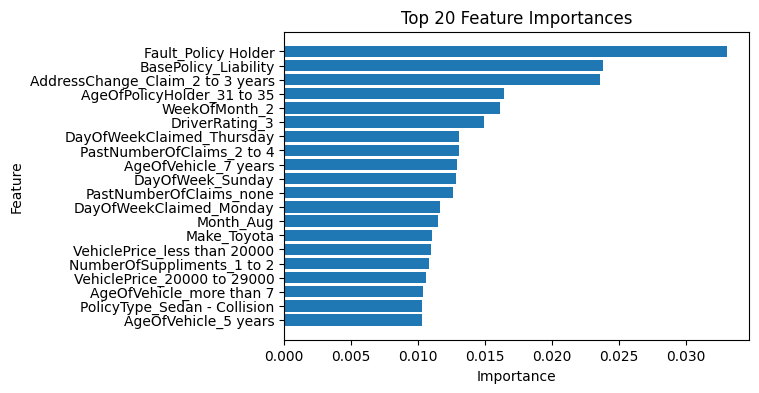

In [435]:
# Get feature importances
feature_importances = dtc.feature_importances_

# Create a DataFrame for better readability
feature_names = X_train_encoded.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select the top 20 features
top_20_features = feature_importance_df.head(20)

# Plot the feature importances
plt.figure(figsize=(6, 4))
plt.barh(top_20_features['Feature'], top_20_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

#### 5.2 Pipeline with gridsearch and finding the best hyperparameters and learning the metrics

In [33]:
# Load the data
data = pd.read_csv('fraud_vihecles.csv')

# Set X and y
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Split the data with stratification on the target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# List of columns to drop
columns_to_drop = ['PolicyNumber'] #'WeekOfMonth', 'DayOfWeek', 'RepNumber', , 'Age'

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns.difference(columns_to_drop))
    ],
    remainder='passthrough'
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_depth': [5, 7, 10, 15],
    'classifier__min_samples_split': [2, 3, 10],
    'classifier__min_samples_leaf': [1, 2, 5, 10],
    'classifier__class_weight': [None, 'balanced']
}

# SMOTE and under-sampling configurations based on the requirements
smote_configs = [
    # 1. Keep the original class proportion
    {'smote': None, 'under_sampler': None},
    
    # 2. Keep the same fraud, downsample non-fraudulent rows by 40%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.6, random_state=42)},
    
    # 3. Keep the same fraud, downsample non-fraudulent rows by 50%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.5, random_state=42)},
    
    # 4. Keep the same fraud, downsample non-fraudulent rows by 60%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.4, random_state=42)},
    
    # 5. Keep the same fraud, downsample non-fraudulent rows by 70%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.3, random_state=42)},
    
    # 6. Keep the same fraud, downsample non-fraudulent rows by 80%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.2, random_state=42)},
    
    # 7. Increase fraud by 100%, downsample non-fraudulent rows by 80%
    {'smote': SMOTE(sampling_strategy=1.0, random_state=42), 'under_sampler': RandomUnderSampler(sampling_strategy=0.8, random_state=42)}
]

# Define the F-beta scorer with beta=1.0 (F1 score)
fbeta_scorer = make_scorer(fbeta_score, beta=1.0, pos_label=1)

# Cross-validation strategies
cv_strategies = [3, 4, 5]

best_results = []

# Loop through SMOTE configurations and CV strategies
for smote_config in smote_configs:
    for cv in cv_strategies:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('under_sampler', smote_config['under_sampler']),
            ('smote', smote_config['smote']),
            ('classifier', DecisionTreeClassifier(random_state=42))
        ])
        
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=fbeta_scorer, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        y_pred = grid_search.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        best_results.append({
            'smote_config': smote_config,
            'cv': cv,
            'best_params': best_params,
            'best_score': best_score,
            'classification_report': report,
            'confusion_matrix': cm
        })
        
        print(f"SMOTE config: {smote_config}, CV: {cv}")
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation score: {best_score}")
        print(classification_report(y_test, y_pred))
        print(pd.DataFrame(cm, index=grid_search.classes_, columns=grid_search.classes_))
        
        print("\nDetailed cross-validation scores:")
        cv_results = pd.DataFrame(grid_search.cv_results_)
        print(cv_results[['mean_test_score', 'std_test_score']])
        print()

# Find the best overall result
best_result = max(best_results, key=lambda x: x['best_score'])

print("\nBest overall result:")
print(f"SMOTE config: {best_result['smote_config']}, CV: {best_result['cv']}")
print(f"Best parameters: {best_result['best_params']}")
print(f"Best cross-validation score: {best_result['best_score']}")
display(pd.DataFrame(best_result['classification_report']).transpose().round(2))
print(pd.DataFrame(best_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))


# Find the worst overall result
worst_result = min(best_results, key=lambda x: x['best_score'])

print("\nWorst overall result:")
print(f"SMOTE config: {worst_result['smote_config']}, CV: {worst_result['cv']}")
print(f"Best parameters: {worst_result['best_params']}")
print(f"Best cross-validation score: {worst_result['best_score']}")
display(pd.DataFrame(worst_result['classification_report']).transpose().round(2))
print(pd.DataFrame(worst_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))


SMOTE config: {'smote': None, 'under_sampler': None}, CV: 3
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 15, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.24069085088798117
              precision    recall  f1-score   support

           0       0.98      0.70      0.82      3624
           1       0.13      0.72      0.23       231

    accuracy                           0.71      3855
   macro avg       0.56      0.71      0.52      3855
weighted avg       0.93      0.71      0.78      3855

      0     1
0  2552  1072
1    64   167

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.072050        0.039749
1          0.072050        0.039749
2          0.072422        0.039873
3          0.072632        0.039700
4          0.072632        0.039700
..              ...             ...
91         0.238789        0.006040
92         0.238789        0.006040
93   

SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.5)}, CV: 5
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10}
Best cross-validation score: 0.25421406465216234
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      3624
           1       0.16      0.44      0.23       231

    accuracy                           0.82      3855
   macro avg       0.56      0.64      0.57      3855
weighted avg       0.91      0.82      0.86      3855

      0    1
0  3071  553
1   129  102

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.250706        0.009131
1          0.251802        0.007526
2          0.253192        0.008173
3          0.250024        0.005082
4          0.250024        0.005082
..              ...             ...
91         0.222765        0.012

SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.2)}, CV: 3
Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.23672661963922148
              precision    recall  f1-score   support

           0       0.99      0.65      0.79      3624
           1       0.14      0.86      0.23       231

    accuracy                           0.66      3855
   macro avg       0.56      0.75      0.51      3855
weighted avg       0.94      0.66      0.75      3855

      0     1
0  2365  1259
1    33   198

Detailed cross-validation scores:
    mean_test_score  std_test_score
0          0.119767        0.061678
1          0.120173        0.061337
2          0.120406        0.061269
3          0.114739        0.066723
4          0.114739        0.066723
..              ...             ...
91         0.223528    

,precision,recall,f1-score,support
0,0.96,0.86,0.91,3624.00
1,0.17,0.45,0.24,231.00
accuracy,0.83,0.83,0.83,0.83
macro avg,0.56,0.65,0.57,3855.00
weighted avg,0.91,0.83,0.87,3855.00


      0    1
0  3100  524
1   126  105

Worst overall result:
SMOTE config: {'smote': SMOTE(random_state=42, sampling_strategy=1.0), 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.8)}, CV: 3
Best parameters: {'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}
Best cross-validation score: 0.23453483334178085


,precision,recall,f1-score,support
0,0.98,0.66,0.79,3624.00
1,0.12,0.74,0.21,231.00
accuracy,0.67,0.67,0.67,0.67
macro avg,0.55,0.70,0.50,3855.00
weighted avg,0.93,0.67,0.76,3855.00


      0     1
0  2409  1215
1    59   172


## 6. Modeling with Random Forest

#### 6.1 Building a benchmark model to take a look what we have

In [450]:
# First, let's instantiate the model
rfc = RandomForestClassifier(random_state=42, max_depth = 15)

# Let's fit the model
rfc.fit(X_train_encoded, y_train)

RandomForestClassifier(max_depth=15, random_state=42)

In [451]:
# Running on train data
cm = confusion_matrix(y_true=y_train,
                      y_pred=rfc.predict(X_train_encoded))
print(pd.DataFrame(cm,
             index=rfc.classes_,
             columns=rfc.classes_))

print(classification_report(y_train, rfc.predict(X_train_encoded)))

       0   1
0  10873   0
1    598  94
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     10873
           1       1.00      0.14      0.24       692

    accuracy                           0.95     11565
   macro avg       0.97      0.57      0.61     11565
weighted avg       0.95      0.95      0.93     11565



In [452]:
# Running on test data
cm = confusion_matrix(y_true=y_test,
                      y_pred=rfc.predict(X_test_encoded))
print(pd.DataFrame(cm,
             index=rfc.classes_,
             columns=rfc.classes_))
print(classification_report(y_test, rfc.predict(X_test_encoded)))

      0  1
0  3624  0
1   230  1
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3624
           1       1.00      0.00      0.01       231

    accuracy                           0.94      3855
   macro avg       0.97      0.50      0.49      3855
weighted avg       0.94      0.94      0.91      3855



#### 6.2 Pipeline with gridsearch and finding the best hyperparameters and learning the metrics using OneHotEncoder

In [453]:
# Load the data
data = pd.read_csv('fraud_vihecles.csv')

# Set X and y
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Split the data with stratification on the target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# List of columns to drop
columns_to_drop = ['PolicyNumber'] #'WeekOfMonth', 'DayOfWeek', 'RepNumber', , 'Age'

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns.difference(columns_to_drop))
    ],
    remainder='passthrough'
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [5, 7, 10, 15, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5, 7, 10],
}

# SMOTE and under-sampling configurations based on the requirements
# SMOTE and under-sampling configurations based on the requirements
smote_configs = [
#     # 1. Keep the original class proportion
#     {'smote': None, 'under_sampler': None}, commented out as not effective
    
    # 2. Keep the same fraud, downsample non-fraudulent rows by 40%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.6, random_state=42)},
    
    # 3. Keep the same fraud, downsample non-fraudulent rows by 50%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.5, random_state=42)},
    
    # 4. Keep the same fraud, downsample non-fraudulent rows by 60%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.4, random_state=42)},
    
    # 5. Keep the same fraud, downsample non-fraudulent rows by 70%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.3, random_state=42)},
    
    # 6. Increase fraud by 100%, downsample non-fraudulent rows by 80%
    {'smote': SMOTE(sampling_strategy=1.0, random_state=42), 'under_sampler': RandomUnderSampler(sampling_strategy=0.8, random_state=42)}
]

# Cross-validation strategies
cv_strategies = [4, 5, 6] # 3 removed as not effective

best_results = []

# Define the F-beta scorer with beta=1.0 (F1 score)
fbeta_scorer = make_scorer(fbeta_score, beta=1.0, pos_label=1)

# Loop through SMOTE configurations and CV strategies
for smote_config in smote_configs:
    for cv in cv_strategies:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('under_sampler', smote_config['under_sampler']),
            ('smote', smote_config['smote']),
            ('classifier', RandomForestClassifier(random_state=42))
        ])
        
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=fbeta_scorer, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        y_pred = grid_search.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        best_results.append({
            'smote_config': smote_config,
            'cv': cv,
            'best_params': best_params,
            'best_score': best_score,
            'classification_report': report,
            'confusion_matrix': cm
        })
        
        print(f"SMOTE config: {smote_config}, CV: {cv}")
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation score: {best_score}")
        print(classification_report(y_test, y_pred))
        print(pd.DataFrame(cm, index=grid_search.classes_, columns=grid_search.classes_))

# Find the best overall result
best_result = max(best_results, key=lambda x: x['best_score'])

print("\nBest overall result:")
print(f"SMOTE config: {best_result['smote_config']}, CV: {best_result['cv']}")
print(f"Best parameters: {best_result['best_params']}")
print(f"Best cross-validation score: {best_result['best_score']}")
display(pd.DataFrame(best_result['classification_report']).transpose().round(2))
print(pd.DataFrame(best_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))


# Find the worst overall result
worst_result = min(best_results, key=lambda x: x['best_score'])

print("\nWorst overall result:")
print(f"SMOTE config: {worst_result['smote_config']}, CV: {worst_result['cv']}")
print(f"Worst parameters: {worst_result['best_params']}")
print(f"Worst cross-validation score: {worst_result['best_score']}")
display(pd.DataFrame(worst_result['classification_report']).transpose().round(2))
print(pd.DataFrame(worst_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))


SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.6)}, CV: 4
Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}
Best cross-validation score: 0.2645516831354884
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      3624
           1       0.17      0.42      0.25       231

    accuracy                           0.85      3855
   macro avg       0.57      0.65      0.58      3855
weighted avg       0.91      0.85      0.87      3855

      0    1
0  3163  461
1   134   97
SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.6)}, CV: 5
Best parameters: {'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.2730487604249042
          

SMOTE config: {'smote': SMOTE(random_state=42, sampling_strategy=1.0), 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.8)}, CV: 5
Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validation score: 0.2455922818247503
              precision    recall  f1-score   support

           0       0.99      0.64      0.77      3624
           1       0.13      0.86      0.23       231

    accuracy                           0.65      3855
   macro avg       0.56      0.75      0.50      3855
weighted avg       0.93      0.65      0.74      3855

      0     1
0  2305  1319
1    33   198
SMOTE config: {'smote': SMOTE(random_state=42, sampling_strategy=1.0), 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.8)}, CV: 6
Best parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'cla

,precision,recall,f1-score,support
0,0.96,0.90,0.93,3624.00
1,0.20,0.39,0.26,231.00
accuracy,0.87,0.87,0.87,0.87
macro avg,0.58,0.64,0.59,3855.00
weighted avg,0.91,0.87,0.89,3855.00


      0    1
0  3263  361
1   142   89

Worst overall result:
SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.3)}, CV: 6
Worst parameters: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Worst cross-validation score: 0.23763425554887688


,precision,recall,f1-score,support
0,0.95,0.96,0.96,3624.00
1,0.27,0.21,0.24,231.00
accuracy,0.92,0.92,0.92,0.92
macro avg,0.61,0.59,0.60,3855.00
weighted avg,0.91,0.92,0.91,3855.00


      0    1
0  3494  130
1   182   49


## 7. Modeling with XGBoost

#### 7.1 Building a benchmark model to take a look what we have

In [381]:
# Instantiate the model
xgb = XGBClassifier(
    max_depth=3,
    min_child_weight=4,
    random_state=42,
    n_estimators=100,
    subsample=0.8
)

# Fit the model
xgb.fit(X_train_encoded, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [382]:
# Running on train data
cm = confusion_matrix(y_true=y_train,
                      y_pred=xgb.predict(X_train_encoded))
print(pd.DataFrame(cm,
             index=xgb.classes_,
             columns=xgb.classes_))

print(classification_report(y_train, xgb.predict(X_train_encoded)))

       0   1
0  10867   6
1    635  57
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10873
           1       0.90      0.08      0.15       692

    accuracy                           0.94     11565
   macro avg       0.92      0.54      0.56     11565
weighted avg       0.94      0.94      0.92     11565



In [383]:
# Running on test data
cm = confusion_matrix(y_true=y_test,
                      y_pred=xgb.predict(X_test_encoded))
print(pd.DataFrame(cm,
             index=xgb.classes_,
             columns=xgb.classes_))
print(classification_report(y_test, xgb.predict(X_test_encoded)))

      0   1
0  3616   8
1   221  10
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3624
           1       0.56      0.04      0.08       231

    accuracy                           0.94      3855
   macro avg       0.75      0.52      0.52      3855
weighted avg       0.92      0.94      0.92      3855



#### 7.2 Pipeline with gridsearch and finding the best hyperparameters and learning the metrics using OneHotEncoder

In [385]:
# Load the data
data = pd.read_csv('fraud_vihecles.csv')

# Set X and y
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Split the data with stratification on the target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# List of columns to drop
columns_to_drop = ['PolicyNumber'] #'WeekOfMonth', 'DayOfWeek', 'RepNumber',  'Age'

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns.difference(columns_to_drop))
    ],
    remainder='passthrough'
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [200, 300],
    'classifier__max_depth': [4, 6, 8, 10, 12],
    'classifier__learning_rate': [0.1, 0.2, 0.3],
    'classifier__min_child_weight': [1, 2, 5, 7],
    'classifier__subsample': [0.8, 0.9],
    'classifier__scale_pos_weight': [10, 13, 15, 17]
}

# SMOTE and under-sampling configurations based on the requirements
smote_configs = [
    # 1. Keep the original class proportion
    {'smote': None, 'under_sampler': None}, # Uncommented since it may still be useful for comparison
    
    # 2. Keep the same fraud, downsample non-fraudulent rows by 40%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.6, random_state=42)},
    
    # 3. Keep the same fraud, downsample non-fraudulent rows by 50%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.5, random_state=42)},
    
    # 4. Keep the same fraud, downsample non-fraudulent rows by 60%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.4, random_state=42)},
    
    # 5. Keep the same fraud, downsample non-fraudulent rows by 70%
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.3, random_state=42)},
    
    # 6. Increase fraud by 100%, downsample non-fraudulent rows by 80%
    {'smote': SMOTE(sampling_strategy=1.0, random_state=42), 'under_sampler': RandomUnderSampler(sampling_strategy=0.8, random_state=42)}
]

# Cross-validation strategies
cv_strategies = [3, 4, 5]

best_results = []

# Define the F-beta scorer with beta=1.0 (F1 score)
fbeta_scorer = make_scorer(fbeta_score, beta=1.0, pos_label=1)

# Loop through SMOTE configurations and CV strategies
for smote_config in smote_configs:
    for cv in cv_strategies:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('under_sampler', smote_config['under_sampler']),
            ('smote', smote_config['smote']),
            ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
        ])
        
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=fbeta_scorer, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        y_pred = grid_search.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        best_results.append({
            'smote_config': smote_config,
            'cv': cv,
            'best_params': best_params,
            'best_score': best_score,
            'classification_report': report,
            'confusion_matrix': cm
        })
        
        print(f"SMOTE config: {smote_config}, CV: {cv}")
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation recall score: {best_score}")
        print(classification_report(y_test, y_pred))
        print(pd.DataFrame(cm, index=grid_search.classes_, columns=grid_search.classes_))

# Find the best overall result
best_result = max(best_results, key=lambda x: x['best_score'])

print("\nBest overall result:")
print(f"SMOTE config: {best_result['smote_config']}, CV: {best_result['cv']}")
print(f"Best parameters: {best_result['best_params']}")
print(f"Best cross-validation score: {best_result['best_score']}")
display(pd.DataFrame(best_result['classification_report']).transpose().round(2))
print(pd.DataFrame(best_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))


# Find the worst overall result
worst_result = min(best_results, key=lambda x: x['best_score'])

print("\nWorst overall result:")
print(f"SMOTE config: {worst_result['smote_config']}, CV: {worst_result['cv']}")
print(f"Worst parameters: {worst_result['best_params']}")
print(f"Worst cross-validation score: {worst_result['best_score']}")
display(pd.DataFrame(worst_result['classification_report']).transpose().round(2))
print(pd.DataFrame(worst_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))

SMOTE config: {'smote': None, 'under_sampler': None}, CV: 3
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 4, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 13, 'classifier__subsample': 0.9}
Best cross-validation recall score: 0.3094048857534198
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      3624
           1       0.20      0.52      0.29       231

    accuracy                           0.85      3855
   macro avg       0.58      0.69      0.60      3855
weighted avg       0.92      0.85      0.88      3855

      0    1
0  3151  473
1   112  119
SMOTE config: {'smote': None, 'under_sampler': None}, CV: 4
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 4, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 10, 'classifier__subsample': 0.9}
Best cross-validation recall sc

SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.3)}, CV: 3
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 10, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 200, 'classifier__scale_pos_weight': 10, 'classifier__subsample': 0.9}
Best cross-validation recall score: 0.29475696642560356
              precision    recall  f1-score   support

           0       0.97      0.82      0.89      3624
           1       0.18      0.60      0.27       231

    accuracy                           0.81      3855
   macro avg       0.57      0.71      0.58      3855
weighted avg       0.92      0.81      0.85      3855

      0    1
0  2973  651
1    92  139
SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.3)}, CV: 4
Best parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__min_child_weight': 2, 'classifier__n_estim

,precision,recall,f1-score,support
0,0.97,0.88,0.92,3624.00
1,0.21,0.53,0.30,231.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.59,0.70,0.61,3855.00
weighted avg,0.92,0.85,0.88,3855.00


      0    1
0  3171  453
1   109  122

Worst overall result:
SMOTE config: {'smote': SMOTE(random_state=42, sampling_strategy=1.0), 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.8)}, CV: 3
Worst parameters: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 6, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 300, 'classifier__scale_pos_weight': 10, 'classifier__subsample': 0.9}
Worst cross-validation score: 0.24405441126729047


,precision,recall,f1-score,support
0,0.98,0.67,0.79,3624.00
1,0.13,0.80,0.23,231.00
accuracy,0.67,0.67,0.67,0.67
macro avg,0.56,0.73,0.51,3855.00
weighted avg,0.93,0.67,0.76,3855.00


      0     1
0  2413  1211
1    46   185


### An exmaple of getting some information that the model shouldn't get (we didn't remove InsuranceNumber feature, it seems like the model rely on it completely, which is something we don't want for our model)

In [455]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = 'fraud_vihecles.csv'
data = pd.read_csv(file_path)

# Encode categorical variables using Label Encoding
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Split the data into training and testing sets
X = data.drop('FraudFound_P', axis=1)
y = data['FraudFound_P']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


xgb_model = XGBClassifier(scale_pos_weight=18, random_state=42, max_depth=6)

xgb_model.fit(X_train, y_train)

# Make predictions
y_train_xgb = xgb_model.predict(X_train)
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
print("XGBoost:")
print(classification_report(y_train, y_train_xgb))

# Evaluate using ROC-AUC and Precision-Recall Curve
roc_auc_xgb = roc_auc_score(y_train, y_train_xgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_train, y_train_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
print(f'ROC-AUC: {roc_auc_xgb}')
print(f'Precision-Recall AUC: {pr_auc_xgb}')

# Evaluate the model
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))

# Evaluate using ROC-AUC and Precision-Recall Curve
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_xgb)
pr_auc_xgb = auc(recall_xgb, precision_xgb)
print(f'ROC-AUC: {roc_auc_xgb}')
print(f'Precision-Recall AUC: {pr_auc_xgb}')


XGBoost:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     11610
           1       0.85      1.00      0.92       726

    accuracy                           0.99     12336
   macro avg       0.93      0.99      0.96     12336
weighted avg       0.99      0.99      0.99     12336

ROC-AUC: 0.9946167097329889
Precision-Recall AUC: 0.926556991774383
XGBoost:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2887
           1       0.65      0.83      0.73       197

    accuracy                           0.96      3084
   macro avg       0.82      0.90      0.85      3084
weighted avg       0.97      0.96      0.96      3084

ROC-AUC: 0.9008297303332461
Precision-Recall AUC: 0.7457045213116231


## 8. Modeling with CatBoost

In [465]:
# Instantiate the model
catboost = CatBoostClassifier(
    depth=5,
    l2_leaf_reg=10,
    random_seed=42,
    iterations=100,
    subsample=0.8,
    learning_rate=0.1
)

# Fit the model
catboost.fit(X_train_encoded, y_train)

0:	learn: 0.5686238	total: 6.2ms	remaining: 614ms
1:	learn: 0.4860533	total: 11.9ms	remaining: 581ms
2:	learn: 0.4231636	total: 16.1ms	remaining: 520ms
3:	learn: 0.3750725	total: 20.1ms	remaining: 483ms
4:	learn: 0.3290235	total: 24.6ms	remaining: 468ms
5:	learn: 0.3013900	total: 30.2ms	remaining: 474ms
6:	learn: 0.2823128	total: 35.3ms	remaining: 469ms
7:	learn: 0.2677111	total: 39.4ms	remaining: 453ms
8:	learn: 0.2454142	total: 43.5ms	remaining: 440ms
9:	learn: 0.2365943	total: 47.5ms	remaining: 427ms
10:	learn: 0.2260465	total: 51.5ms	remaining: 416ms
11:	learn: 0.2178444	total: 56.4ms	remaining: 414ms
12:	learn: 0.2147050	total: 61.8ms	remaining: 414ms
13:	learn: 0.2075794	total: 66.1ms	remaining: 406ms
14:	learn: 0.1998217	total: 69.9ms	remaining: 396ms
15:	learn: 0.1982397	total: 73.7ms	remaining: 387ms
16:	learn: 0.1935750	total: 78ms	remaining: 381ms
17:	learn: 0.1927168	total: 82.5ms	remaining: 376ms
18:	learn: 0.1893758	total: 87ms	remaining: 371ms
19:	learn: 0.1881994	total:

In [466]:
# Running on train data
cm = confusion_matrix(y_true=y_train,
                      y_pred=catboost.predict(X_train_encoded))
print(pd.DataFrame(cm,
             index=catboost.classes_,
             columns=catboost.classes_))

print(classification_report(y_train, catboost.predict(X_train_encoded)))

       0   1
0  10873   0
1    661  31
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10873
           1       1.00      0.04      0.09       692

    accuracy                           0.94     11565
   macro avg       0.97      0.52      0.53     11565
weighted avg       0.95      0.94      0.92     11565



In [467]:
# Running on test data
cm = confusion_matrix(y_true=y_test,
                      y_pred=catboost.predict(X_test_encoded))
print(pd.DataFrame(cm,
             index=catboost.classes_,
             columns=catboost.classes_))
print(classification_report(y_test, catboost.predict(X_test_encoded)))

      0  1
0  3624  0
1   225  6
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3624
           1       1.00      0.03      0.05       231

    accuracy                           0.94      3855
   macro avg       0.97      0.51      0.51      3855
weighted avg       0.95      0.94      0.91      3855



In [468]:
# Load the data
data = pd.read_csv('fraud_vihecles.csv')

# Set X and y
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Split the data with stratification on the target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# List of columns to drop
columns_to_drop = ['PolicyNumber']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns.difference(columns_to_drop))
    ],
    remainder='passthrough'
)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__iterations': [200, 300],
    'classifier__depth': [4, 6, 8],
    'classifier__learning_rate': [0.3, 0.4],
    'classifier__l2_leaf_reg': [1, 2],
    'classifier__subsample': [0.8],
    'classifier__scale_pos_weight': [8, 10, 13]
}

# SMOTE and under-sampling configurations based on the requirements
smote_configs = [
    # Keep the original class proportion
    {'smote': None, 'under_sampler': None},
    # Keep the same fraud, downsample non-fraudulent rows by different percentages
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.6, random_state=42)},
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.5, random_state=42)},
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.4, random_state=42)},
    {'smote': None, 'under_sampler': RandomUnderSampler(sampling_strategy=0.3, random_state=42)},
    # Increase fraud by 100%, downsample non-fraudulent rows by 80%
    {'smote': SMOTE(sampling_strategy=1.0, random_state=42), 'under_sampler': RandomUnderSampler(sampling_strategy=0.8, random_state=42)}
]

# Cross-validation strategies
cv_strategies = [3, 4, 5]

best_results = []

# Define the F-beta scorer with beta=1.0 (F1 score)
fbeta_scorer = make_scorer(fbeta_score, beta=1.0, pos_label=1)

# Loop through SMOTE configurations and CV strategies
for smote_config in smote_configs:
    for cv in cv_strategies:
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('under_sampler', smote_config['under_sampler']),
            ('smote', smote_config['smote']),
            ('classifier', CatBoostClassifier(random_state=42, eval_metric='Logloss', verbose=0))
        ])
        
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=fbeta_scorer, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        
        y_pred = grid_search.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        
        best_results.append({
            'smote_config': smote_config,
            'cv': cv,
            'best_params': best_params,
            'best_score': best_score,
            'classification_report': report,
            'confusion_matrix': cm
        })
        
        print(f"SMOTE config: {smote_config}, CV: {cv}")
        print(f"Best parameters: {best_params}")
        print(f"Best cross-validation score: {best_score}")
        print(classification_report(y_test, y_pred))
        print(pd.DataFrame(cm, index=grid_search.classes_, columns=grid_search.classes_))

# Find the best overall result
best_result = max(best_results, key=lambda x: x['best_score'])

print("\nBest overall result:")
print(f"SMOTE config: {best_result['smote_config']}, CV: {best_result['cv']}")
print(f"Best parameters: {best_result['best_params']}")
print(f"Best cross-validation score: {best_result['best_score']}")
display(pd.DataFrame(best_result['classification_report']).transpose().round(2))
print(pd.DataFrame(best_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))

# Find the worst overall result
worst_result = min(best_results, key=lambda x: x['best_score'])

print("\nWorst overall result:")
print(f"SMOTE config: {worst_result['smote_config']}, CV: {worst_result['cv']}")
print(f"Worst parameters: {worst_result['best_params']}")
print(f"Worst cross-validation score: {worst_result['best_score']}")
display(pd.DataFrame(worst_result['classification_report']).transpose().round(2))
print(pd.DataFrame(worst_result['confusion_matrix'], index=grid_search.classes_, columns=grid_search.classes_))


SMOTE config: {'smote': None, 'under_sampler': None}, CV: 3
Best parameters: {'classifier__depth': 4, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 2, 'classifier__learning_rate': 0.3, 'classifier__scale_pos_weight': 13, 'classifier__subsample': 0.8}
Best cross-validation score: 0.2992001909029773
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      3624
           1       0.21      0.52      0.30       231

    accuracy                           0.85      3855
   macro avg       0.59      0.70      0.61      3855
weighted avg       0.92      0.85      0.88      3855

      0    1
0  3177  447
1   112  119
SMOTE config: {'smote': None, 'under_sampler': None}, CV: 4
Best parameters: {'classifier__depth': 4, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 2, 'classifier__learning_rate': 0.3, 'classifier__scale_pos_weight': 8, 'classifier__subsample': 0.8}
Best cross-validation score: 0.29013124685043723
            

SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.3)}, CV: 3
Best parameters: {'classifier__depth': 8, 'classifier__iterations': 300, 'classifier__l2_leaf_reg': 2, 'classifier__learning_rate': 0.3, 'classifier__scale_pos_weight': 8, 'classifier__subsample': 0.8}
Best cross-validation score: 0.2886256941884005
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      3624
           1       0.18      0.67      0.29       231

    accuracy                           0.80      3855
   macro avg       0.58      0.74      0.59      3855
weighted avg       0.93      0.80      0.85      3855

      0    1
0  2935  689
1    76  155
SMOTE config: {'smote': None, 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.3)}, CV: 4
Best parameters: {'classifier__depth': 6, 'classifier__iterations': 300, 'classifier__l2_leaf_reg': 2, 'classifier__learning_rate': 0.4, 'classifier__scale_

,precision,recall,f1-score,support
0,0.97,0.88,0.92,3624.00
1,0.21,0.52,0.30,231.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.59,0.70,0.61,3855.00
weighted avg,0.92,0.85,0.88,3855.00


      0    1
0  3177  447
1   112  119

Worst overall result:
SMOTE config: {'smote': SMOTE(random_state=42, sampling_strategy=1.0), 'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.8)}, CV: 3
Worst parameters: {'classifier__depth': 6, 'classifier__iterations': 300, 'classifier__l2_leaf_reg': 2, 'classifier__learning_rate': 0.4, 'classifier__scale_pos_weight': 8, 'classifier__subsample': 0.8}
Worst cross-validation score: 0.24000979395197622


,precision,recall,f1-score,support
0,0.99,0.64,0.77,3624.00
1,0.13,0.87,0.23,231.00
accuracy,0.65,0.65,0.65,0.65
macro avg,0.56,0.75,0.50,3855.00
weighted avg,0.94,0.65,0.74,3855.00


      0     1
0  2307  1317
1    30   201


## 8. Trying a voter on 4 models (apart from Decision Trees) out

In [473]:
# Load the data
data = pd.read_csv('fraud_vihecles.csv')

# Set X and y
X = data.drop(columns=['FraudFound_P'])
y = data['FraudFound_P']

# Split the data with stratification on the target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# List of columns to drop
columns_to_drop = ['PolicyNumber']

# Define the preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', columns_to_drop),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X_train.columns.difference(columns_to_drop))
    ],
    remainder='passthrough'
)

# Define the hyperparameters for Logistic Regression, Random Forest, XGBoost and CatBoost

lr_params = {
    'C': 1,
    'penalty': 'l1',
    'solver': 'liblinear',
    'random_state': 42
}

rfc_params = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'random_state': 42
}

xgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.2,
    'max_depth': 4,
    'scale_pos_weight': 13,
    'subsample': 0.8,
    'min_child_weight': 5,
    'random_state': 42
}

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.3,
    'depth': 4,
    'random_state': 42,
    'verbose': False,
    'l2_leaf_reg': 2,
    'scale_pos_weight': 13,
    'subsample': 0.8
}


# Instantiate the models
lr_model = LogisticRegression(**lr_params)
rfc_model = RandomForestClassifier(**rfc_params)
xgb_model = XGBClassifier(**xgb_params)
catboost_model = CatBoostClassifier(**catboost_params)

# Define the SMOTE and under-sampling configurations for each model
smote_config_lr = {
    'smote': None, 
    'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.5)
}

smote_config_rfc = {
    'smote': None, 
    'under_sampler': RandomUnderSampler(random_state=42, sampling_strategy=0.4)
}

smote_config_xgb = {
    'smote': None, 
    'under_sampler': None
}

smote_config_catboost = {
    'smote': None, 
    'under_sampler': None
}

# Define the pipelines for each model
pipeline_lr = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under_sampler', smote_config_lr['under_sampler']),
    ('smote', smote_config_lr['smote']),
    ('classifier', lr_model)
])

pipeline_rfc = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under_sampler', smote_config_rfc['under_sampler']),
    ('smote', smote_config_rfc['smote']),
    ('classifier', rfc_model)
])

pipeline_xgb = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under_sampler', smote_config_xgb['under_sampler']),
    ('smote', smote_config_xgb['smote']),
    ('classifier', xgb_model)
])

pipeline_catboost = ImbPipeline([
    ('preprocessor', preprocessor),
    ('under_sampler', smote_config_catboost['under_sampler']),
    ('smote', smote_config_catboost['smote']),
    ('classifier', catboost_model)
])

# Fit the pipelines to the training data
pipeline_lr.fit(X_train, y_train)
pipeline_rfc.fit(X_train, y_train)
pipeline_xgb.fit(X_train, y_train)
pipeline_catboost.fit(X_train, y_train)

# Predict on the test data
y_pred_lr = pipeline_lr.predict(X_test)
y_pred_rfc = pipeline_rfc.predict(X_test)
y_pred_xgb = pipeline_xgb.predict(X_test)
y_pred_catboost = pipeline_catboost.predict(X_test)

# Combine the predictions using VotingClassifier
voter = VotingClassifier(estimators=[
     ('lr', pipeline_lr),
    ('rfc', pipeline_rfc),
    ('xgb', pipeline_xgb),
    ('catboost', pipeline_catboost)
], voting='soft')

voter.fit(X_train, y_train)
y_pred_voter = voter.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_pred_voter, output_dict=True)
cm = confusion_matrix(y_test, y_pred_voter)

results = {
    'classification_report': report,
    'confusion_matrix': cm
}

# Print the results
print(f"Combined model results:")
print(classification_report(y_test, y_pred_voter))
print(pd.DataFrame(cm, index=voter.classes_, columns=voter.classes_))

Combined model results:
              precision    recall  f1-score   support

           0       0.97      0.87      0.92      3624
           1       0.20      0.51      0.29       231

    accuracy                           0.85      3855
   macro avg       0.59      0.69      0.60      3855
weighted avg       0.92      0.85      0.88      3855

      0    1
0  3166  458
1   113  118


# Conclusions

1. None of the models showed decent results to 'be used in production'
2. XGBoost happened to show the best results
3. Voting didn't really improve the prediciton power